# Prediciting Air Pollution in Ulaanbaatar using Fast.AI

### Installing and importing libraries

In [ ]:
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade
!pip install -Uqq kaggle --upgrade

     |████████████████████████████████| 194kB 6.5MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 12.8MB 218kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
import fastai
import fastcore
import datetime as dt
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.3.0
Fastcore version: 1.3.19


In [ ]:
from fastai.tabular.all import *

In [ ]:
!nvidia-smi

Fri Apr 23 08:55:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      2MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Loading Data

In [ ]:
path = Path('/content/')
path.is_absolute()

True

In [ ]:
Path.BASE_PATH = path

In [ ]:
ls

pm_test.csv  pm_train.csv  sample_data/  sample_submission.csv  weather.csv


In [ ]:
train = pd.read_csv(path/'pm_train.csv', low_memory= False)
test = pd.read_csv(path/'pm_test.csv', low_memory = False)
weather = pd.read_csv(path/'weather.csv', low_memory = False)

### Feature Engineering and Cleaning

In [ ]:
weather_features = weather[['date', 'temperature', 'dewPoint', 'humidity']]
weather_features.head()

,date,temperature,dewPoint,humidity
0,2015-09-01 00:00:00,16.39,12.09,0.76
1,2015-09-01 01:00:00,16.26,10.99,0.71
2,2015-09-01 02:00:00,15.26,10.99,0.76
3,2015-09-01 03:00:00,15.26,10.99,0.76
4,2015-09-01 04:00:00,14.26,10.99,0.81


In [ ]:
df = pd.concat([train,test])

In [ ]:
df = pd.merge(df, weather_features, on= 'date', how='left').set_index('date')

In [ ]:
df.index = pd.to_datetime(df.index)

#### Creating previous feature values (Lag Features)

In [ ]:
def create_lag(data):
  data['aqi_1'] = data.aqi.shift(periods=1)
  data['temperature_1'] = data.temperature.shift(periods=1)
  data['dewPoint_1'] = data.dewPoint.shift(periods=1)
  data['humidity_1'] = data.humidity.shift(periods=1)
  data['aqi_2'] = data.aqi.shift(periods=2)
  data['temperature_2'] = data.temperature.shift(periods=2)
  data['dewPoint_2'] = data.dewPoint.shift(periods=2)
  data['humidity_2'] = data.humidity.shift(periods=2)
  data['aqi_3'] = data.aqi.shift(periods=3)
  data['temperature_3'] = data.temperature.shift(periods=3)
  data['dewPoint_3'] = data.dewPoint.shift(periods=3)
  data['humidity_3'] = data.humidity.shift(periods=3)
  return data

In [ ]:
df = create_lag(df)
df = df.dropna().reset_index()

### Building DataLoader

In [ ]:
cont, cat = cont_cat_split(df, 1, dep_var='aqi')
procs = [Categorify, FillMissing, Normalize]

In [ ]:
valid_idx = df.sample(frac=0.1, random_state=42).index.values

In [ ]:
dls = TabularDataLoaders.from_df(df, 
                                 path, 
                                 procs=procs, 
                                 cat_names=cat, 
                                 cont_names=cont, 
                                 y_names="aqi", 
                                 valid_idx=valid_idx,
                                 bs = 64)

In [ ]:
dls.show_batch()

,date,type,source,station,ID,latitude,longitude,temperature,dewPoint,humidity,aqi_1,temperature_1,dewPoint_1,humidity_1,aqi_2,temperature_2,dewPoint_2,humidity_2,aqi_3,temperature_3,dewPoint_3,humidity_3,aqi
0,2016-08-01 12:00:00,PM10,Agaar.mn,Амгалан,103473.002499,47.913429,106.997910,29.480000,10.859999,0.32,149.000001,29.479999,10.859999,0.32,146.999999,29.480000,10.859999,0.32,43.000002,29.479999,10.859999,0.32,148.0
1,2018-10-08 05:00:00,PM10,Agaar.mn,Амгалан,322652.996253,47.913429,106.997910,-2.730000,-7.000000,0.72,30.000001,-2.730000,-7.000000,0.72,29.000000,-2.730000,-7.000000,0.72,34.000001,-2.730000,-7.000000,0.72,31.0
2,2017-02-16 15:00:00,PM10,Agaar.mn,МҮОНРТ,177738.999315,47.929733,106.888626,-14.720001,-19.010001,0.70,104.000000,-14.720000,-19.010000,0.70,105.000000,-14.720000,-19.010000,0.70,105.000000,-14.720000,-19.010000,0.70,100.0
3,2017-06-25 06:00:00,PM10,Agaar.mn,100 айл,226035.997492,47.932907,106.921387,12.260000,8.000001,0.75,62.999997,12.260000,8.000000,0.75,36.999998,12.260000,7.999999,0.75,60.999998,12.260000,8.000000,0.75,60.0
4,2016-08-28 09:00:00,PM10,Agaar.mn,Баянхошуу,111774.000755,47.957561,106.822754,10.240000,3.050000,0.61,25.999998,10.240000,3.050000,0.61,81.999999,10.240000,3.050000,0.61,26.999998,10.239999,3.050000,0.61,80.0
5,2019-11-06 23:00:00,PM2.5,Agaar.mn,Баянхошуу,355753.996299,47.957561,106.822754,-6.010000,-11.880000,0.63,211.999996,-6.010000,-11.880000,0.63,114.000000,-6.010000,-11.880000,0.63,240.999999,-6.010000,-11.880000,0.63,55.0
6,2018-08-09 19:00:00,PM2.5,Stateair.mn,АНУ-ын Элчин сайдын яам,309729.002769,47.928387,106.929466,23.249999,10.990000,0.46,37.000002,23.250000,10.990000,0.46,41.000002,23.250001,10.989999,0.46,40.999999,23.250000,10.990000,0.46,7.0
7,2016-12-13 02:00:00,PM2.5,Agaar.mn,Бөхийн өргөө,150839.000128,47.917606,106.937363,-29.230001,-32.439998,0.74,421.000007,-29.230000,-32.439998,0.74,232.999998,-29.229999,-32.439998,0.74,217.999997,-29.230000,-32.439999,0.74,432.0
8,2018-10-18 08:00:00,PM2.5,Agaar.mn,МҮОНРТ,324619.999619,47.929733,106.888626,-7.730000,-10.000000,0.84,99.000000,-7.730000,-10.000000,0.84,107.000000,-7.730000,-10.000000,0.84,104.000000,-7.730000,-10.000000,0.84,106.0
9,2017-02-05 23:00:00,PM10,Agaar.mn,МҮОНРТ,173400.999965,47.929733,106.888626,-11.130000,-16.030001,0.67,67.000000,-11.130000,-16.030001,0.67,69.000001,-11.130001,-16.030001,0.67,67.000000,-11.130000,-16.030001,0.67,69.0


In [ ]:
learn = tabular_learner(dls, metrics = rmse, layers=[500,250])

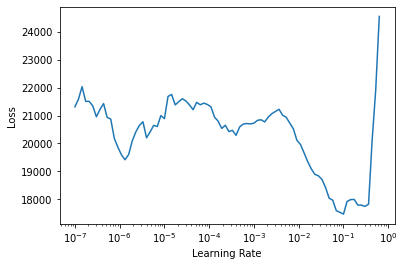

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_min)

epoch,train_loss,valid_loss,_rmse,time
0,1122.777344,976.525818,31.249413,01:20
1,708.930420,668.277832,25.851072,01:19
2,582.431396,491.332672,22.166025,01:19
3,332.029541,399.161530,19.979029,01:20
4,218.350342,374.022919,19.339668,01:19
